In [104]:
import wandb

In [105]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [106]:
wandb.init(project="lorenz_rnn", group="Lorenz",save_code=True,notes="Lorenz RNN run and evaluation")

In [3]:
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import seaborn as sns

In [4]:
torch.manual_seed(7) # Set the random seed
np.random.seed(7) # Set the random seed

In [5]:
def visualize(real=None, train=None, save=None, title=''):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    
    ax.set_title('Lorenz Attractor \n'+title)

    if train is not None:
      sns.set(style='darkgrid')
      
      z = np.array([o.detach().numpy() for o in train])
      z = np.reshape(z, [-1,3])
      sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Greens', s=1)
      #cbar = fig.colorbar(sc)

    if real is not None:
      #sns.set(style='darkgrid')
      
      z = np.array([o.detach().numpy() for o in real])
      z = np.reshape(z, [-1,3])
      ax.scatter(z[:,0], z[:,1], z[:,2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)
      #sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Reds', s=1)
      #cbar = fig.colorbar(sc)
      #ax.scatter(, marker='.', c=c,cmap='viridis', alpha=0.5, linewidths=0, s=45)

    fig.canvas.draw()
    fig.canvas.flush_events()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
    plt.show()

In [6]:
class Lorenz(nn.Module):
    """
    chaotic lorenz system
    """
    def __init__(self):
        super(Lorenz, self).__init__()
        self.lin = nn.Linear(5, 3, bias=False)
        W = torch.tensor([[-10., 10., 0., 0., 0.],
                          [28., -1., 0., -1., 0.],
                          [0., 0., -8. / 3., 0., 1.]])
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        y = y = torch.ones([1, 5])
        y[0][0] = x[0][0]
        y[0][1] = x[0][1]
        y[0][2] = x[0][2]
        y[0][3] = x[0][0] * x[0][2]
        y[0][4] = x[0][0] * x[0][1]
        return self.lin(y)

true_y0 = torch.tensor([[1., 0., 0.]])  # initial condition
t = torch.linspace(0., 50., 5000)  # t is from 0 to 25 for 1000 data points

# generating training data
with torch.no_grad():
    data = odeint(Lorenz(), true_y0, t)



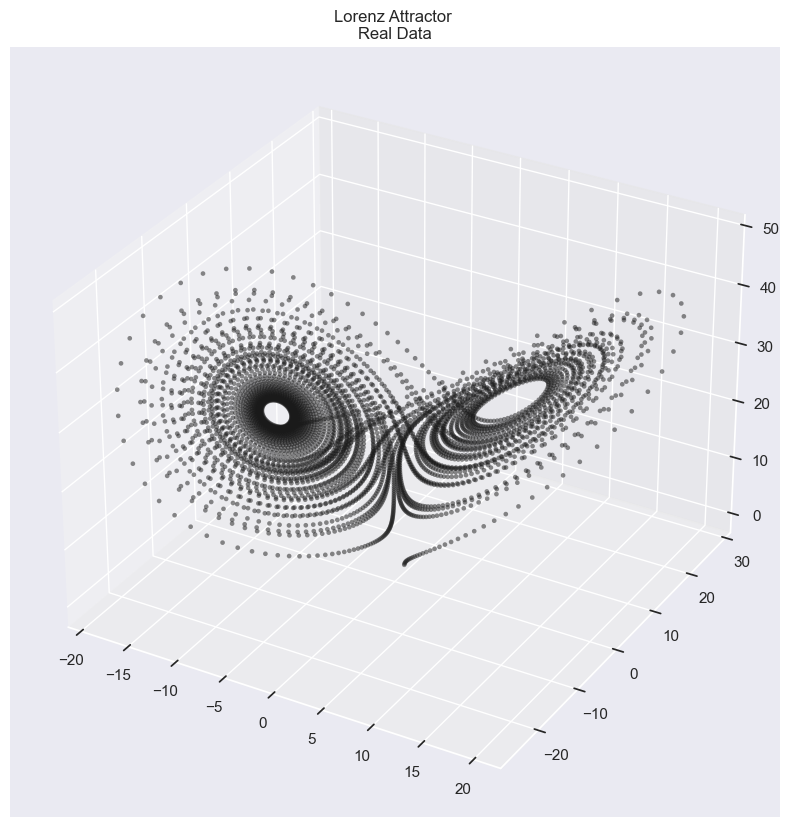

In [291]:
visualize(real=data,save='real',title='Real Data')

In [112]:
# # Define the number of random starting points (N)
# N = 10  # You can change this to your desired value

# # Generate random starting points using NumPy
# x0_np = -15 + 30 * np.random.random((N, 3))

# # Convert the NumPy array to a PyTorch tensor
# x0_tensor = torch.tensor(x0_np, dtype=torch.float32)

In [7]:
data_tensor = torch.load('data_tensor.pt')

In [8]:
train = data_tensor[:6]
val = data_tensor[6]
test = data_tensor[7:]

In [115]:
train = train.view(30000,1,3)

In [9]:
class LorenzRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LorenzRNN, self).__init__()

        self.hidden_size = hidden_size

        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size,batch_first=True)
        self.activation = nn.ReLU()
        # Define the linear layer to map from hidden space to output space
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        # Reshape the input to match the batch_first format (batch_size, seq_len, input_size)
        

        # Initialize hidden state with zeros
        hidden_state = torch.zeros(1, input_seq.size(0), self.hidden_size)

        # Get RNN outputs and hidden state
        rnn_out, hidden_state = self.rnn(input_seq, hidden_state)
        act_out = self.activation(rnn_out)
        # Apply linear layer to the output of the last time step
        output = self.linear(act_out)

        # Remove the additional batch dimension from the output
        #output = output.squeeze(0)

        return output.squeeze(0)

# Define input size, hidden size, and output size
input_size = 3
hidden_size = 512
output_size = 3




In [10]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.stack(X).squeeze(2), torch.stack(y).squeeze(1).squeeze(2)
 
lookback = 30


In [118]:
X_train, y_train = create_dataset(train, lookback=lookback)

In [11]:
def evaluate(model,dataset,lookback=1,label='',visualizer = visualize):
    import torch.utils.data as lon
    predictions = []
    losses = []
    criterion = nn.MSELoss()
    for i in range(len(dataset)):
        
        x_test, y_test = create_dataset(dataset[i], lookback=lookback)
        test_loader =lon.DataLoader(lon.TensorDataset(x_test, y_test), shuffle=False, batch_size=1)
        with torch.no_grad():
            preds = []
            test_batch_loss = []

            for x, y in test_loader:
                # Get the initial input (first time step)
                input_seq = x[:, :1, :]
                break
            
            preds.append(input_seq.view(1,3))
            for x, y in test_loader:
                
                # Forward pass for the current time step
                predicted_lorenz = model(input_seq)

                # Append the prediction for this time step to preds
                preds.append(predicted_lorenz)

                # Update the input_seq for the next time step (use the predicted value)
                input_seq = predicted_lorenz.unsqueeze(1)
                
                # Compute the loss for this time step
                loss = criterion(predicted_lorenz, y.view(1,3))
                test_batch_loss.append(loss.item())

            # Stack all the predictions along the time axis
            preds = torch.stack(preds, dim=1)
            
            
            # Compute the mean loss across all time steps
            losses.append(np.mean(test_batch_loss))
            predictions.append(preds)
        visualizer(real=dataset[i],train=preds,save='preds'+str(i),title=f'Predictions for Lorenz Attractor {label} {i}')
        preds = preds.squeeze(0)
        x_pred = preds[:, 0]
        y_pred = preds[ :,1]
        z_pred = preds[ :,2]
        x_train = dataset[i][:, :, 0]
        y_train = dataset[i][:, :, 1]
        z_train = dataset[i][:, :, 2]
        
        fig, ax = plt.subplots(3, 1, figsize=(12, 12))
        ax[0].plot(x_train, label='True')
        ax[0].plot(x_pred, label='Predicted',linestyle='--')

        ax[0].set_ylabel('X')
        #ax[0].set_xlim(0, 1000)
        ax[0].set_title('Projection')
        ax[0].legend()

        ax[1].plot(y_train, label='True')
        ax[1].plot(y_pred, label='Predicted',linestyle='--')
        ax[1].set_ylabel('Y')
        ax[1].set_title('Projection')
        ax[1].legend()

        ax[2].plot(z_train, label='True')
        ax[2].plot(z_pred, label='Predicted',linestyle='--')
        ax[2].set_ylabel('Z')
        #ax[2].set_xlim(0, 400)
        ax[2].set_title('Projection')
        ax[2].legend()

        plt.tight_layout()
        plt.savefig(f'PNG/RNN/projections on {label} Set '+str(i)+'.png', format='png', dpi=400)
        plt.show()
        
    return predictions, losses
        
        

In [120]:
val = val.view(5000,1,3)

In [121]:
x_val, y_val = create_dataset(val, lookback=lookback)

In [12]:
import torch.utils.data as lon

In [123]:
train_loader = lon.DataLoader(lon.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)

In [124]:
val_loader = lon.DataLoader(lon.TensorDataset(x_val, y_val), shuffle=False, batch_size=8)

In [125]:
model = LorenzRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

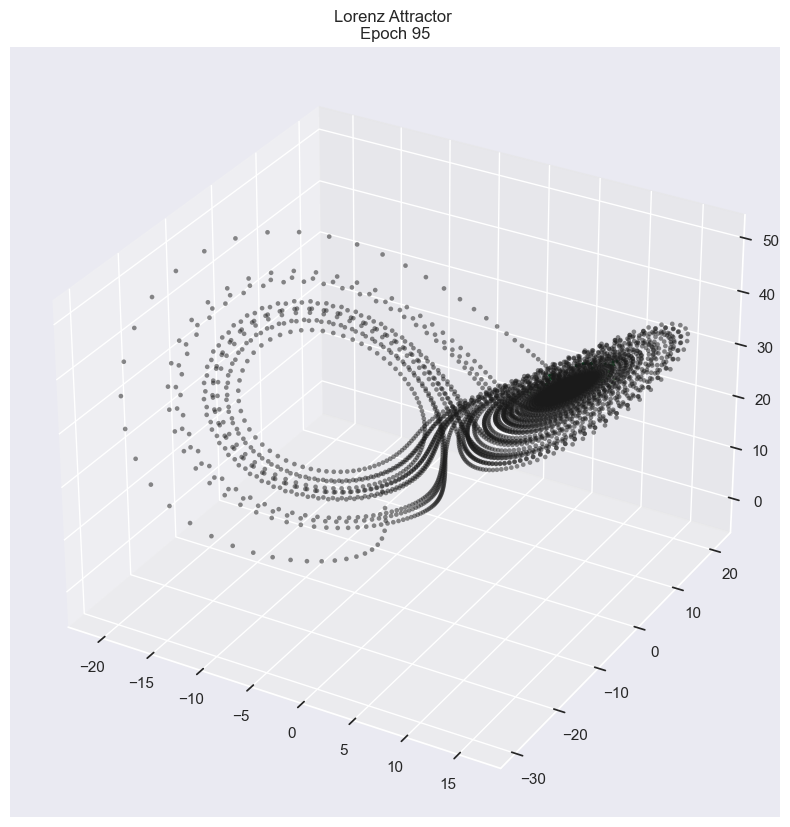

Epoch [96/100], Loss: 0.5147


In [126]:
val_losses = []
epoch_losses = []
num_epochs = 1000
best_loss = 1000.
for epoch in range(num_epochs):
    batch_losses = []
    for x,y in train_loader:
        optimizer.zero_grad()
        # Forward pass
        predicted_lorenz = model(x)

        # Compute the loss
        loss = criterion(predicted_lorenz, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    epoch_loss = np.mean(batch_losses)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'lorenz_rnn.pt')
    epoch_losses.append(epoch_loss)
    
    if epoch % 5 == 0:
        
        with torch.no_grad():
            val_batch_loss = []
            for x,y in val_loader:
                
                # Forward pass
                predicted_lorenz = model(x)

                # Compute the loss
                loss = criterion(predicted_lorenz, y)
                val_batch_loss.append(loss.item())
            val_losses.append(np.mean(val_batch_loss))
            visualize(real=val, 
                                train=predicted_lorenz,save='PNG/RNN/{}'.format(epoch),title='Epoch {}'.format(epoch))
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            clear_output(wait=True)


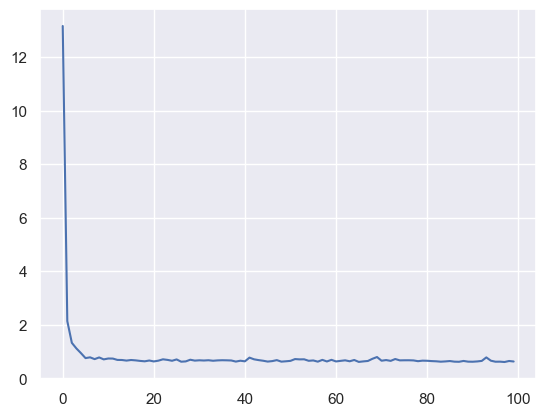

In [150]:
plt.plot(epoch_losses, label='Training loss')

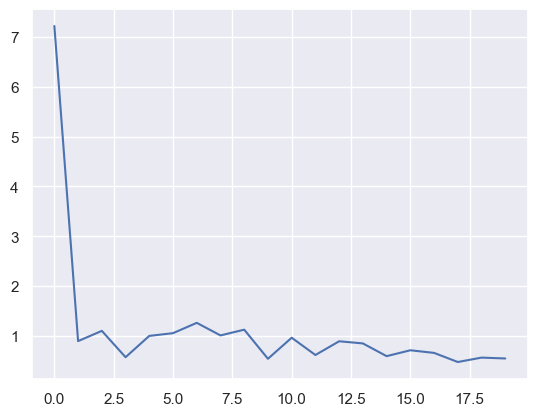

In [151]:
plt.plot(val_losses, label='Validation loss')

In [152]:
training_losses = torch.tensor(epoch_losses)

In [154]:
torch.save(training_losses, 'training_losses_rnn.pt')

In [153]:
validation_losses = torch.tensor(val_losses)

In [155]:
torch.save(validation_losses, 'validation_losses_rnn.pt')

In [244]:
test_loader = lon.DataLoader(lon.TensorDataset(x_test, y_test), shuffle=False, batch_size=1)

In [13]:
test_model = LorenzRNN(input_size, hidden_size, output_size)

In [14]:
test_model.load_state_dict(torch.load('lorenz_rnn.pt'))

<All keys matched successfully>

In [248]:
test_losses = []
predictions = []
with torch.no_grad():
            preds = []
            test_batch_loss = []
            for x,y in test_loader:
                
                # Forward pass
                predicted_lorenz = test_model(x)
                preds.append(predicted_lorenz)
                # Compute the loss
                loss = criterion(predicted_lorenz, y.view(1,3))
                test_batch_loss.append(loss.item())
            predictions = torch.stack(preds)
            test_losses.append(np.mean(test_batch_loss))

In [249]:
test_losses

[0.7678535492615516]

In [250]:
predictions.shape

torch.Size([4999, 1, 3])

In [315]:
predictions.shape

torch.Size([5000, 3])

In [253]:
x_pred = predictions[:,:, 0]
y_pred = predictions[:, :,1]
z_pred = predictions[:, :,2]

In [254]:
x_train = test[0][:, :, 0]
y_train = test[0][:, :, 1]
z_train = test[0][:, :, 2]

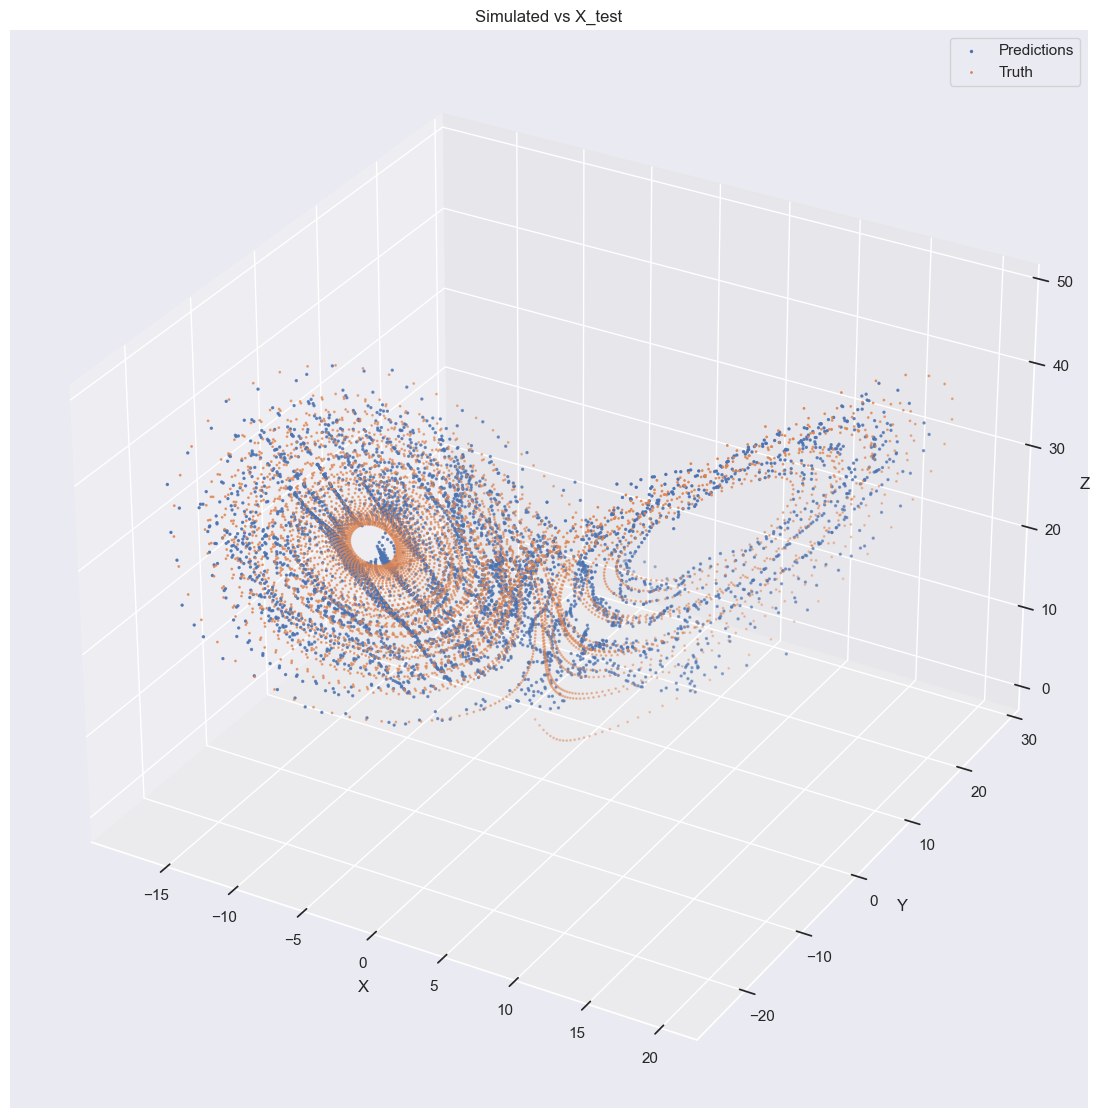

In [255]:
# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=2)
ax.scatter(x_train, y_train, z_train, label='Truth',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulated vs X_test')
ax.legend()

# Show the plot
plt.show()

In [326]:
test_losses

[392.8365589102928]

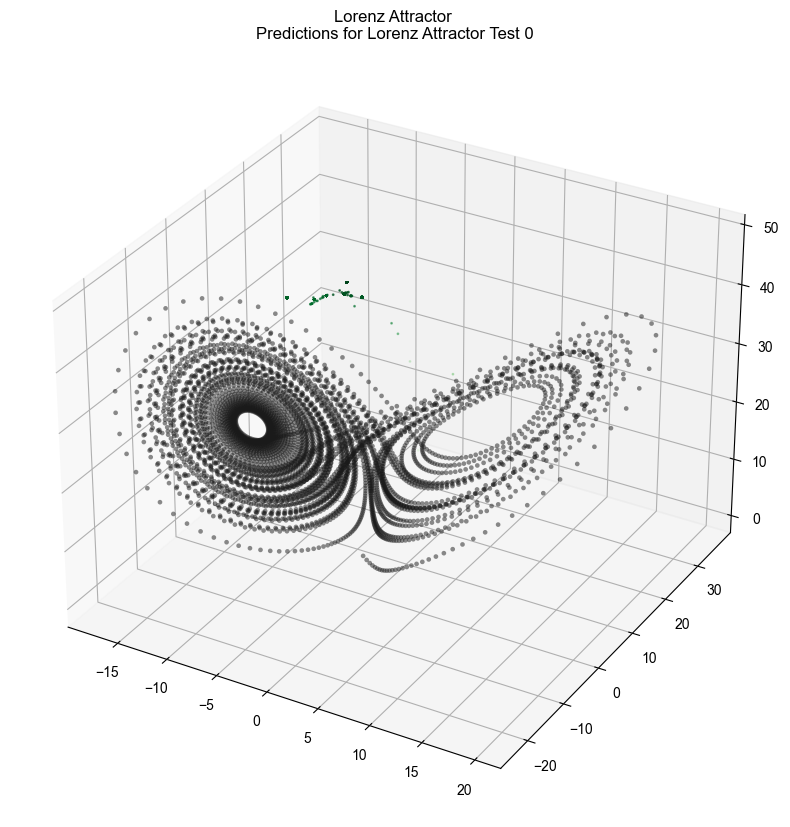

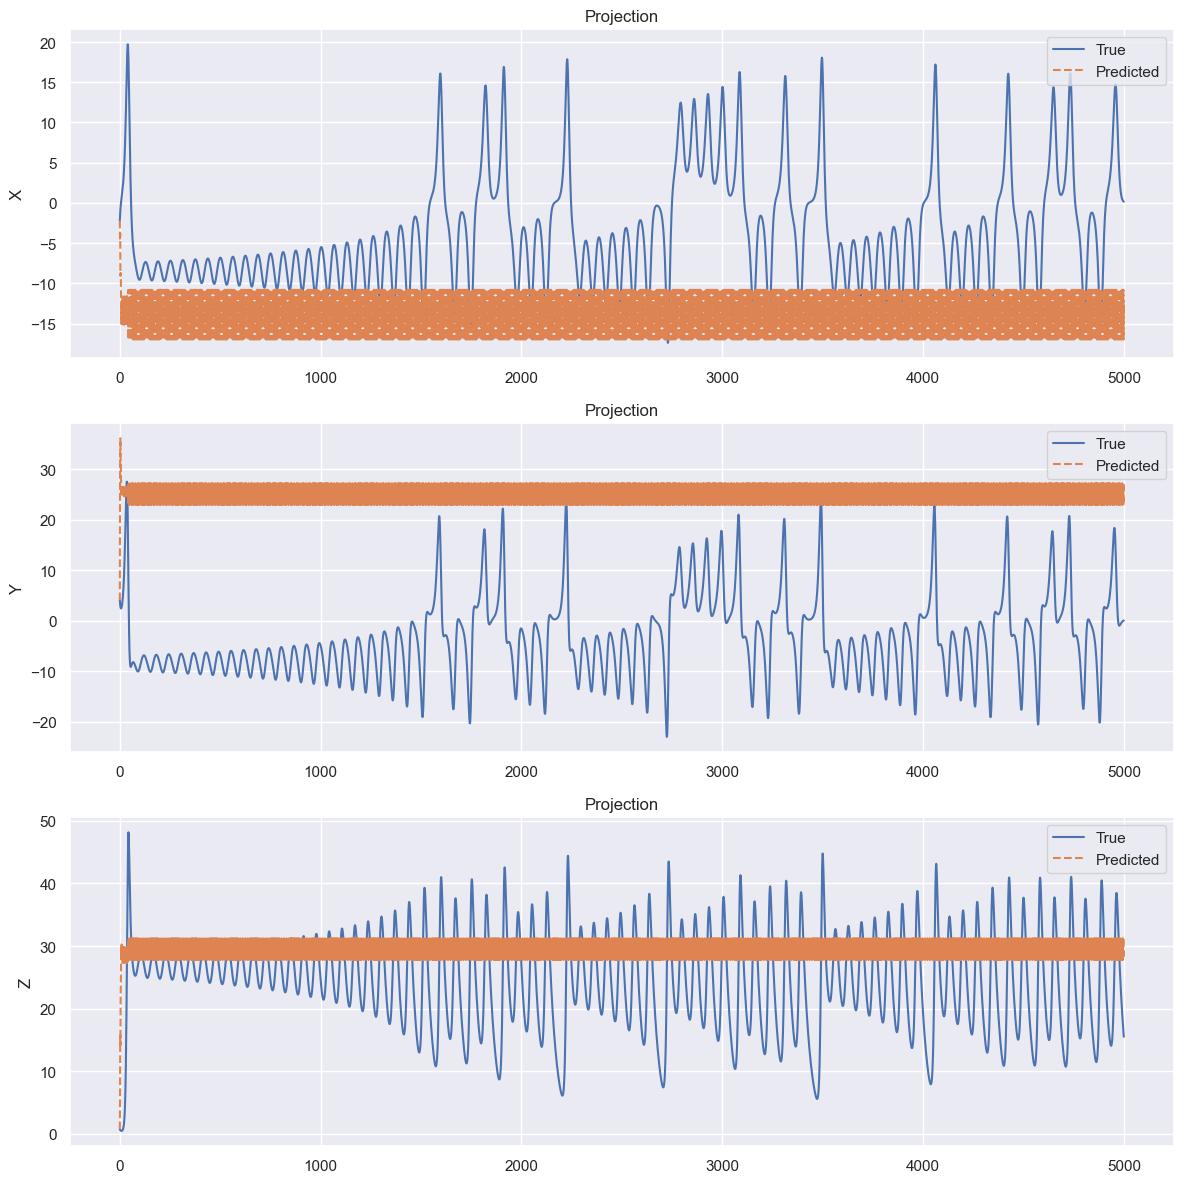

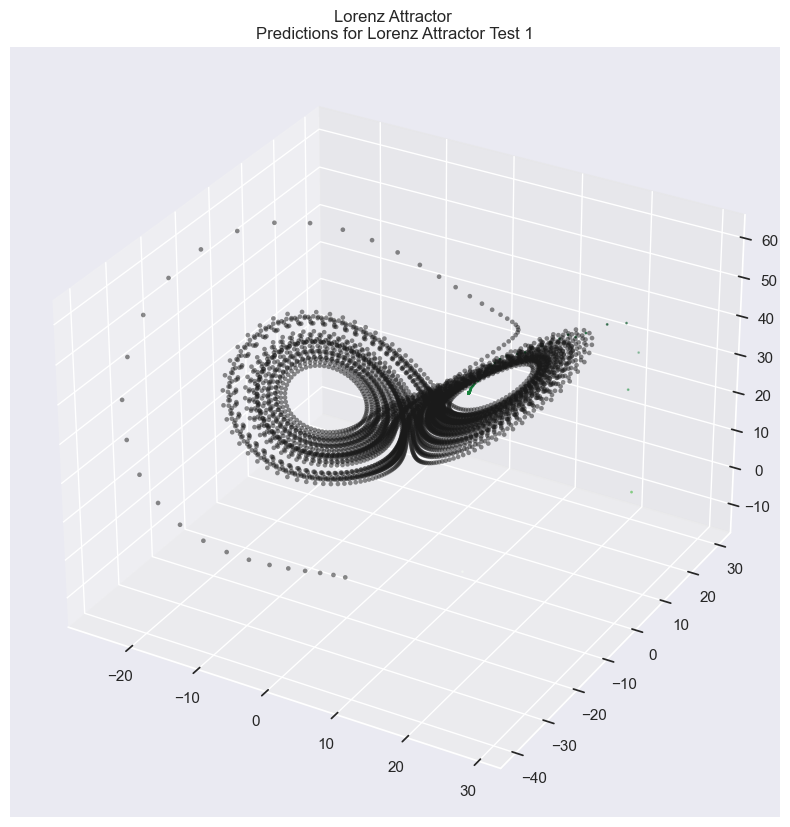

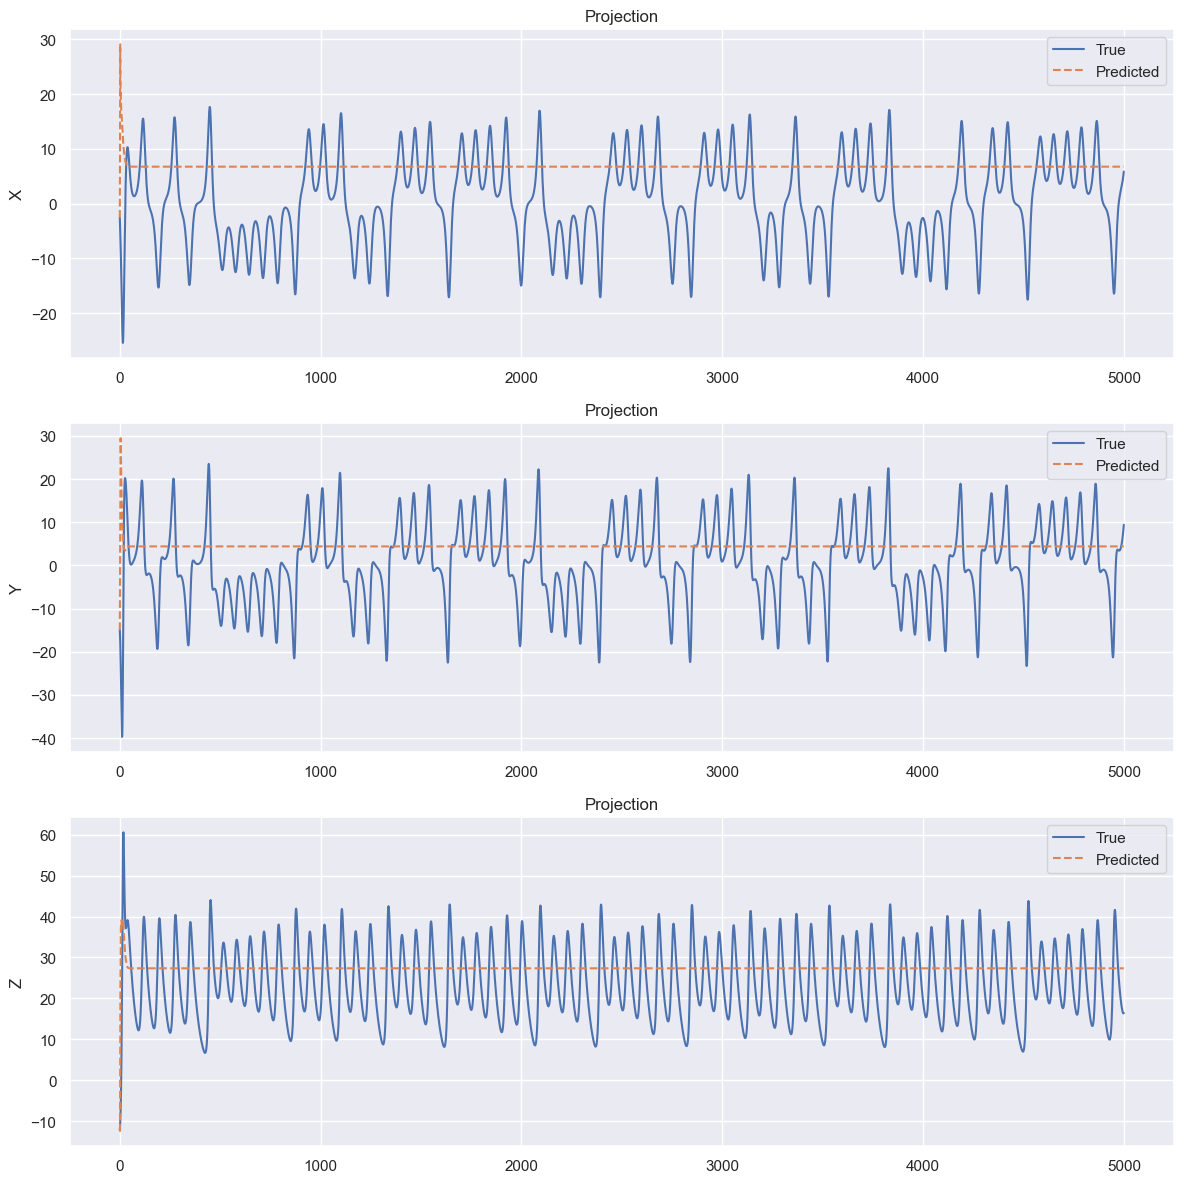

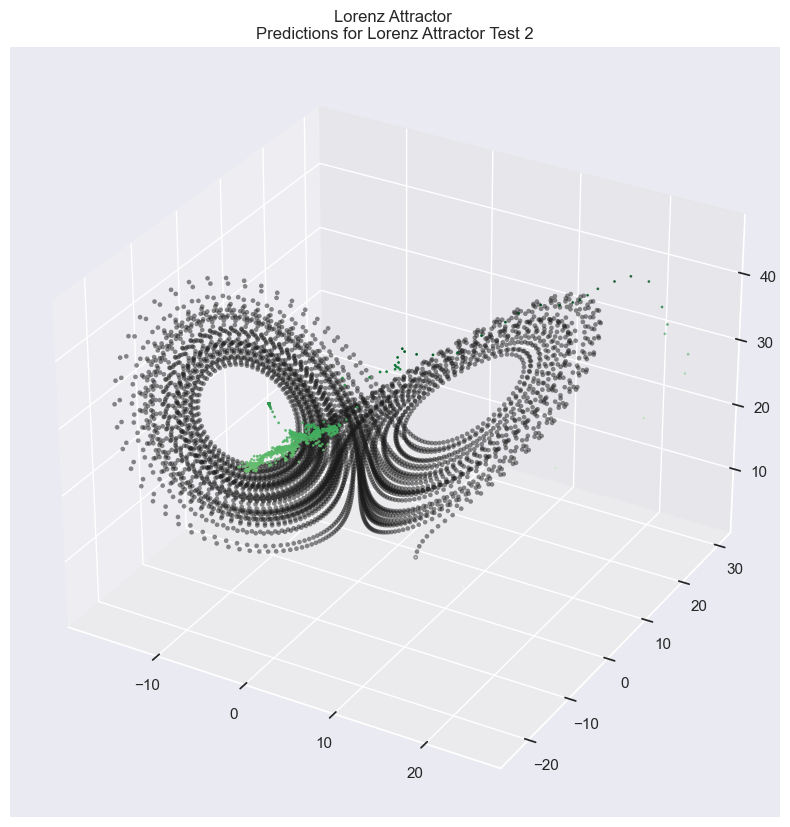

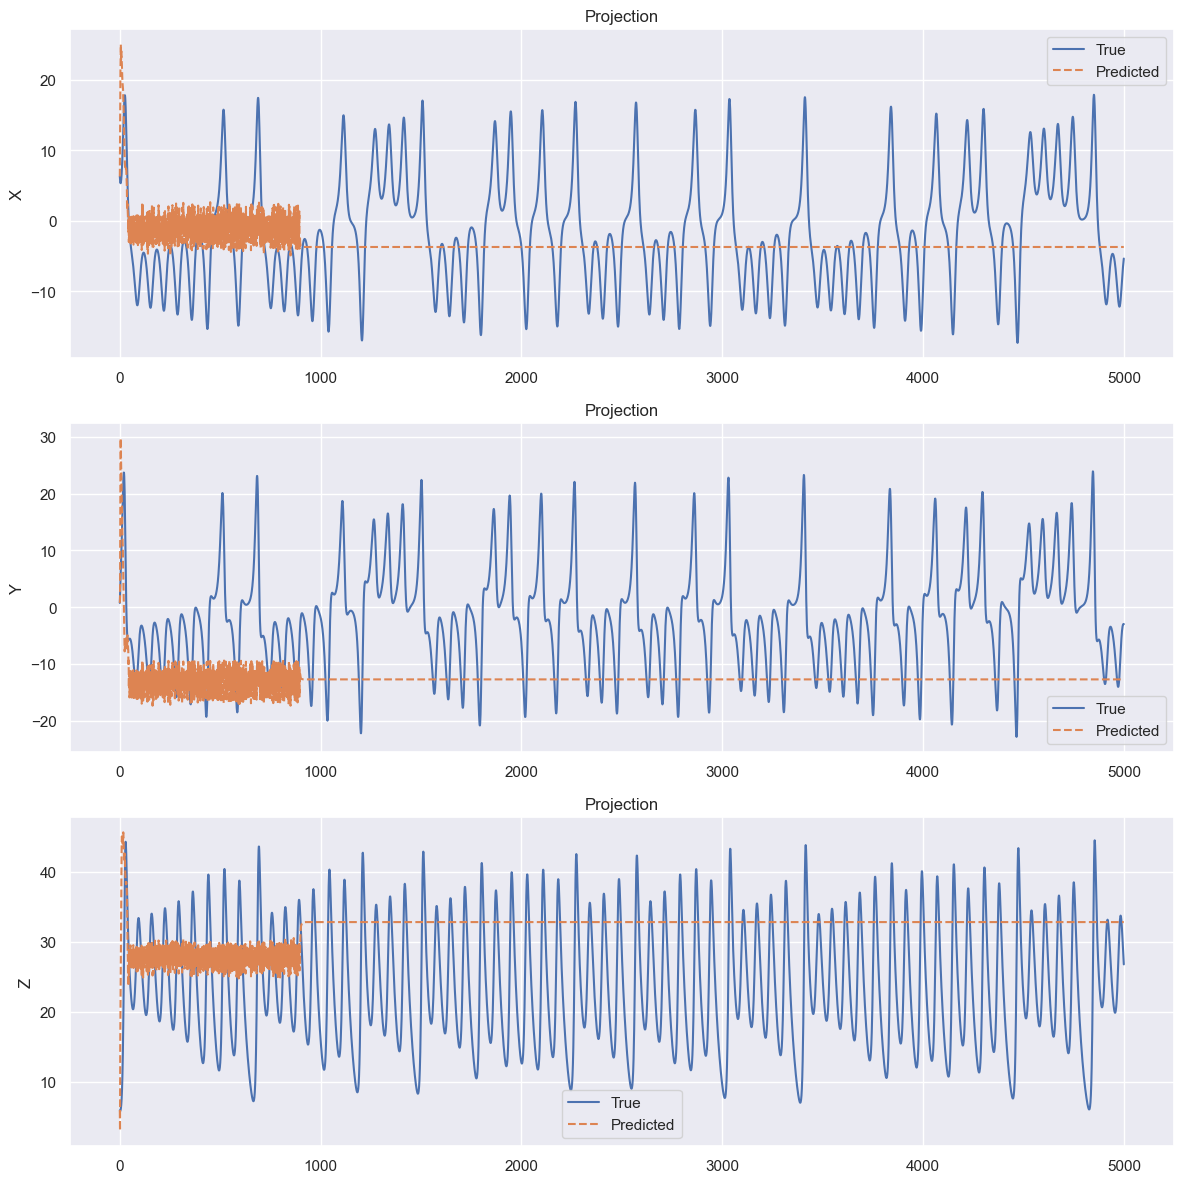

In [15]:
preds,losses = evaluate(test_model,test,label='Test')

In [16]:
losses

[392.8365589102928, 99.64526514912586, 137.67089800568527]

In [403]:
torch.save(losses, 'test_losses_rnn.pt')

In [23]:
def plot_vector_field(predictions,label):
    
    for idx in range(len(predictions)):
        
        
        positions = predictions[idx][:, 0, :]  # Extracting the 3 components as positions

        # Create a new tensor with requires_grad=True
        positions = positions.clone().detach().requires_grad_(True)

        # Calculate the vector field by taking the derivatives of positions
        vector_field = torch.autograd.grad(positions, positions, torch.ones_like(positions), create_graph=True)[0]

        # Extract the x, y, and z components of the vector field
        U = vector_field[:, 0]
        V = vector_field[:, 1]
        W = vector_field[:, 2]

        # Move tensors to CPU before converting to NumPy arrays
        positions = positions.cpu().detach().numpy()
        U = U.cpu().detach().numpy()
        V = V.cpu().detach().numpy()
        W = W.cpu().detach().numpy()

        # Create a subset of positions for the arrows
        arrow_step = 1  # Adjust this to change the density of arrows
        arrow_positions = positions[::arrow_step]

        # Calculate arrow directions by normalizing the vector field components
        magnitude = np.sqrt(U**2 + V**2 + W**2)
        arrow_U = U / magnitude
        arrow_V = V / magnitude

        # Plot the vector field with arrows
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.quiver(arrow_positions[:, 0], arrow_positions[:, 1], arrow_U[::arrow_step], arrow_V[::arrow_step], width=0.004, alpha=0.6)
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.set_xlabel('')   # Remove x-axis label
        ax.set_ylabel('')   # Remove y-axis label
        plt.title(f'Lorenz RNN Vector Field of {label}_{idx}  Predictions')
        plt.savefig(f'PNG/RNN/lorenz_RNN_Vector_Field{idx}_{label}.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
        plt.tight_layout()
        plt.show()

In [18]:
preds = torch.stack(preds)

In [19]:
preds = preds.squeeze(1)

In [20]:
preds = preds.unsqueeze(2)

In [21]:
preds.shape

torch.Size([3, 5000, 1, 3])

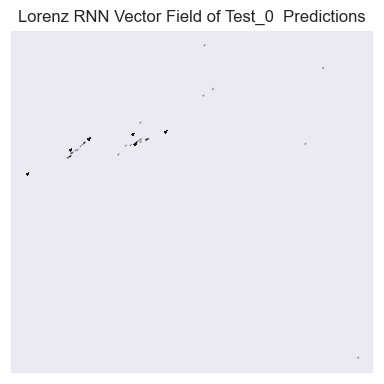

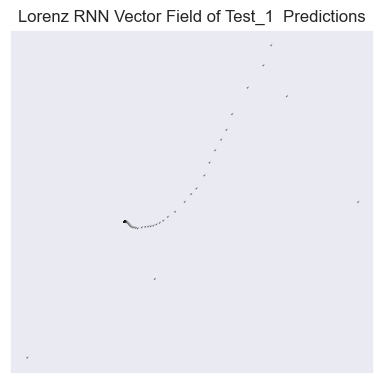

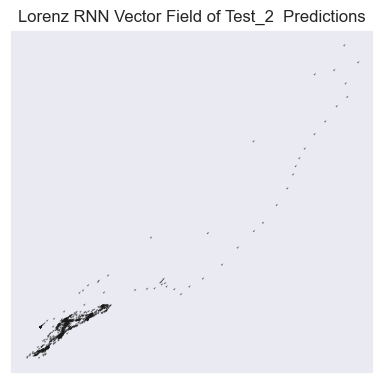

In [24]:
plot_vector_field(preds,label='Test')

In [385]:
train.shape

torch.Size([6, 5000, 1, 3])

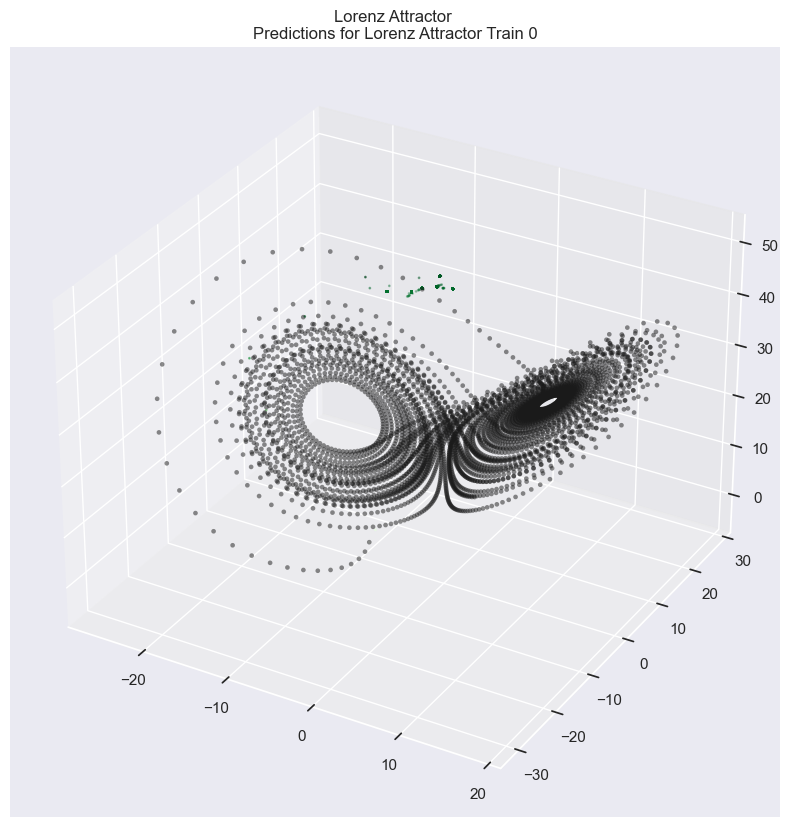

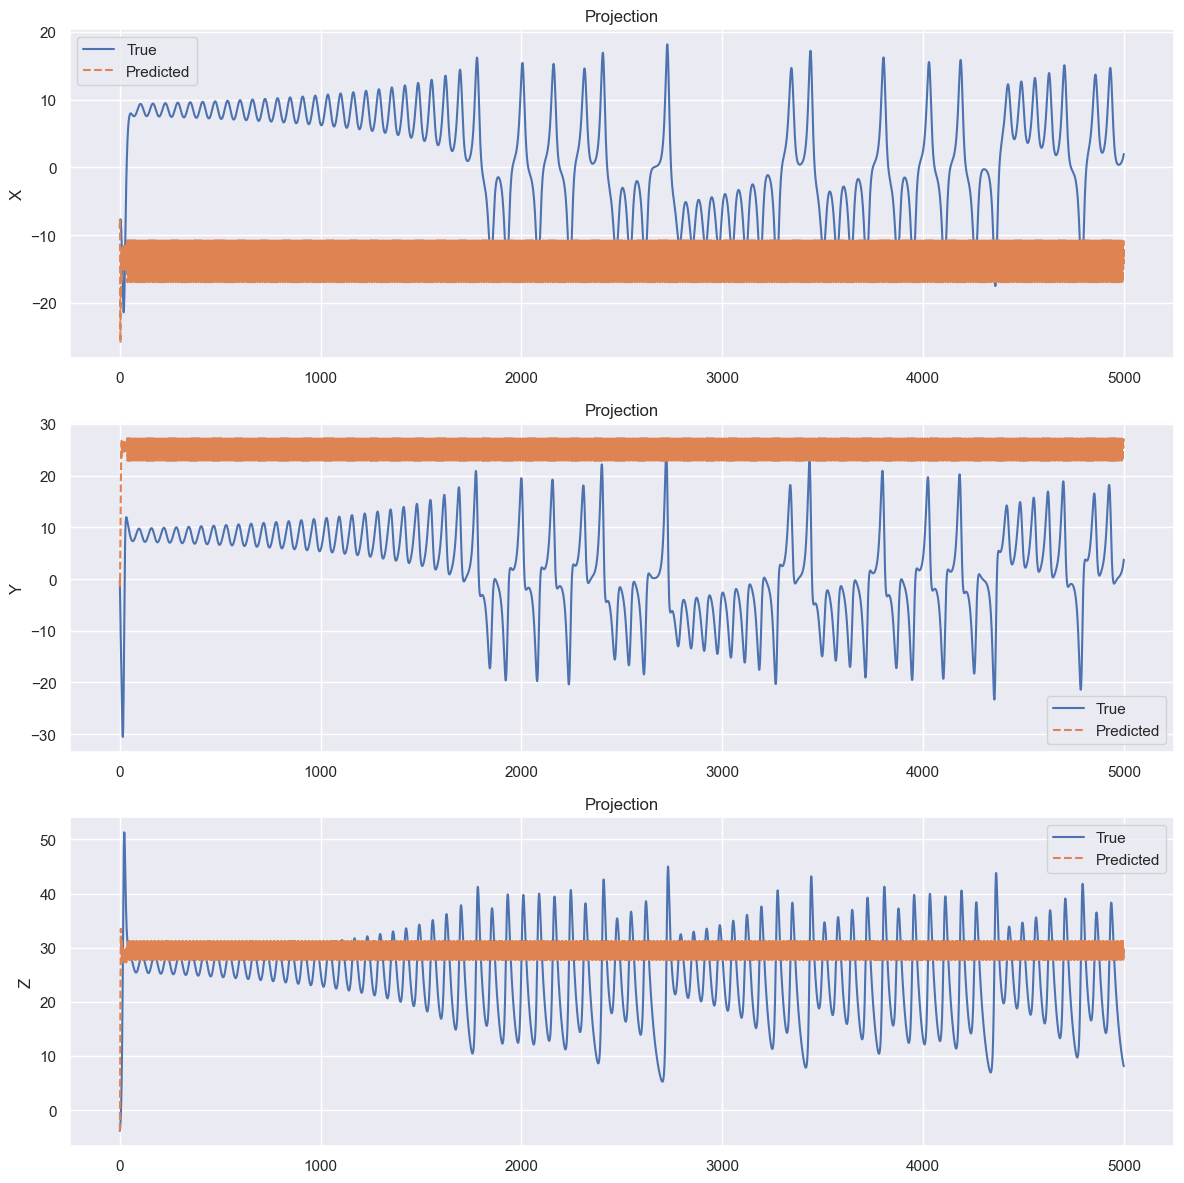

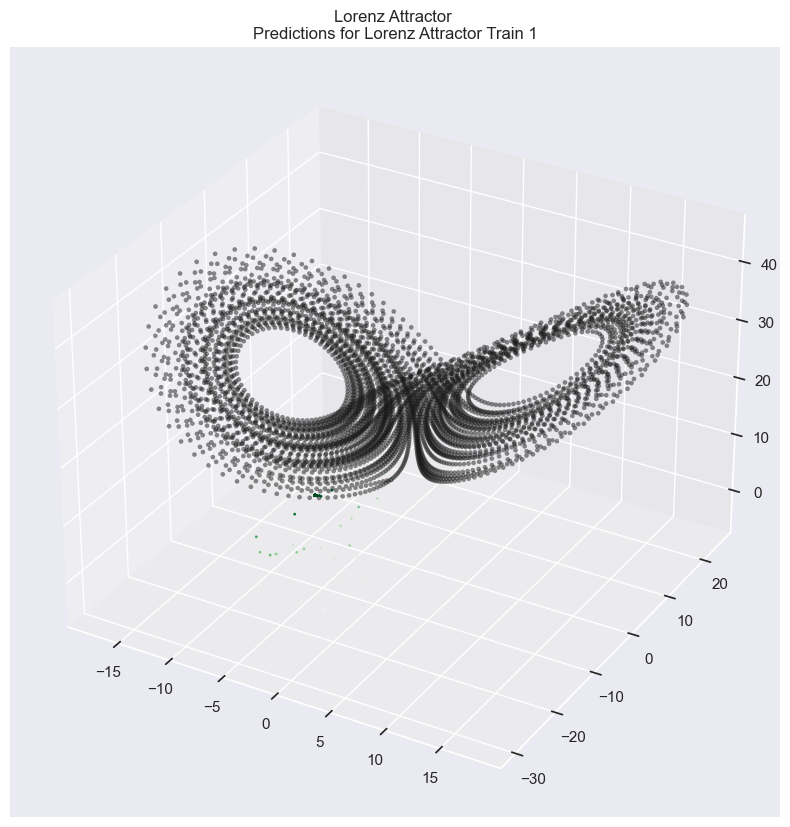

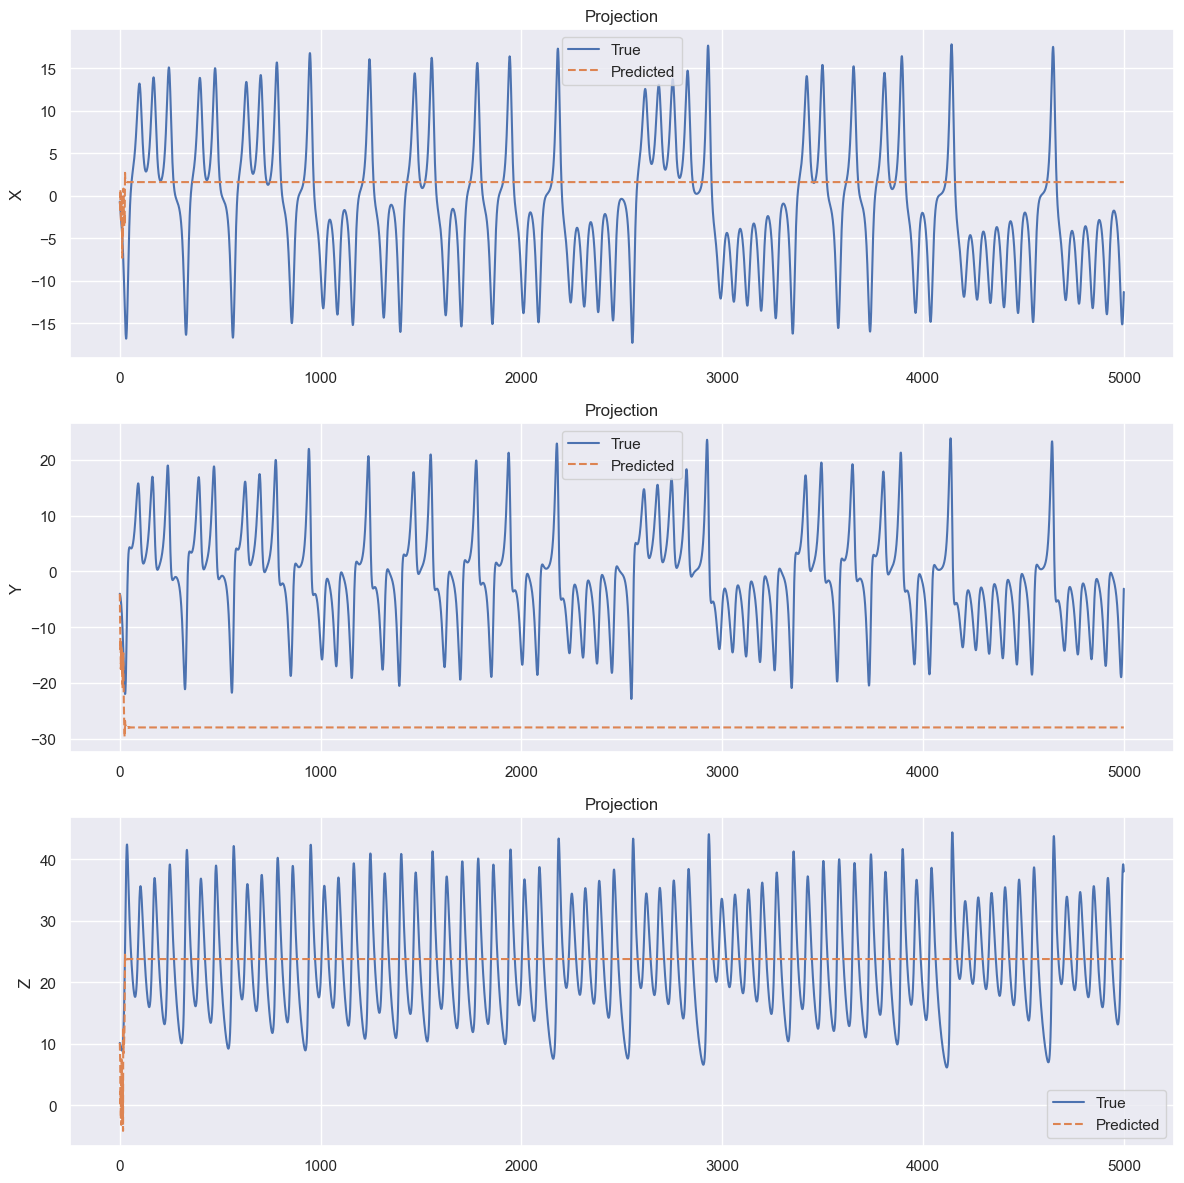

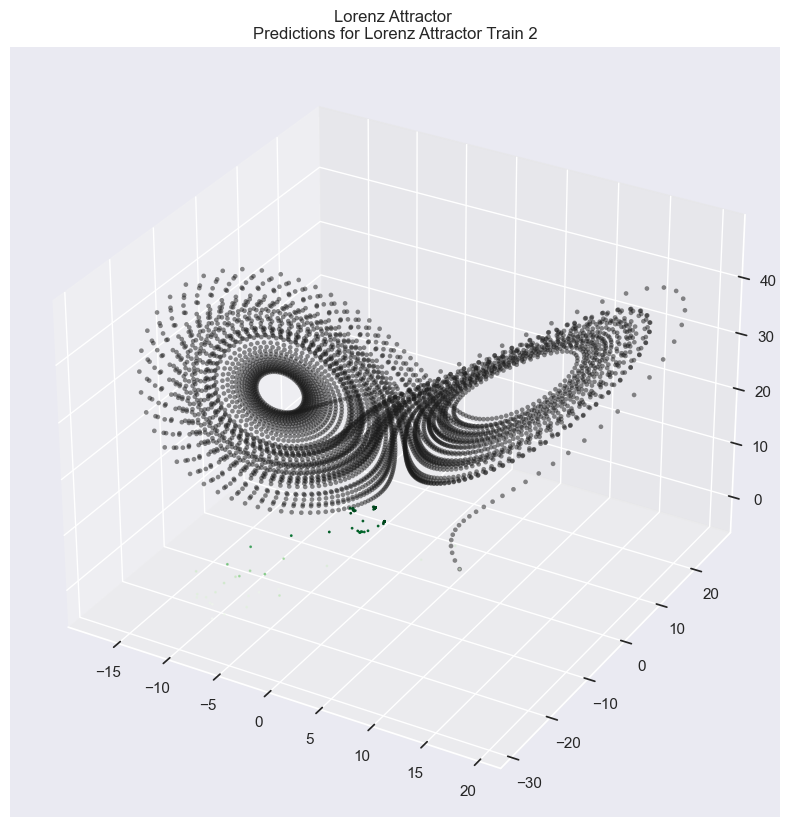

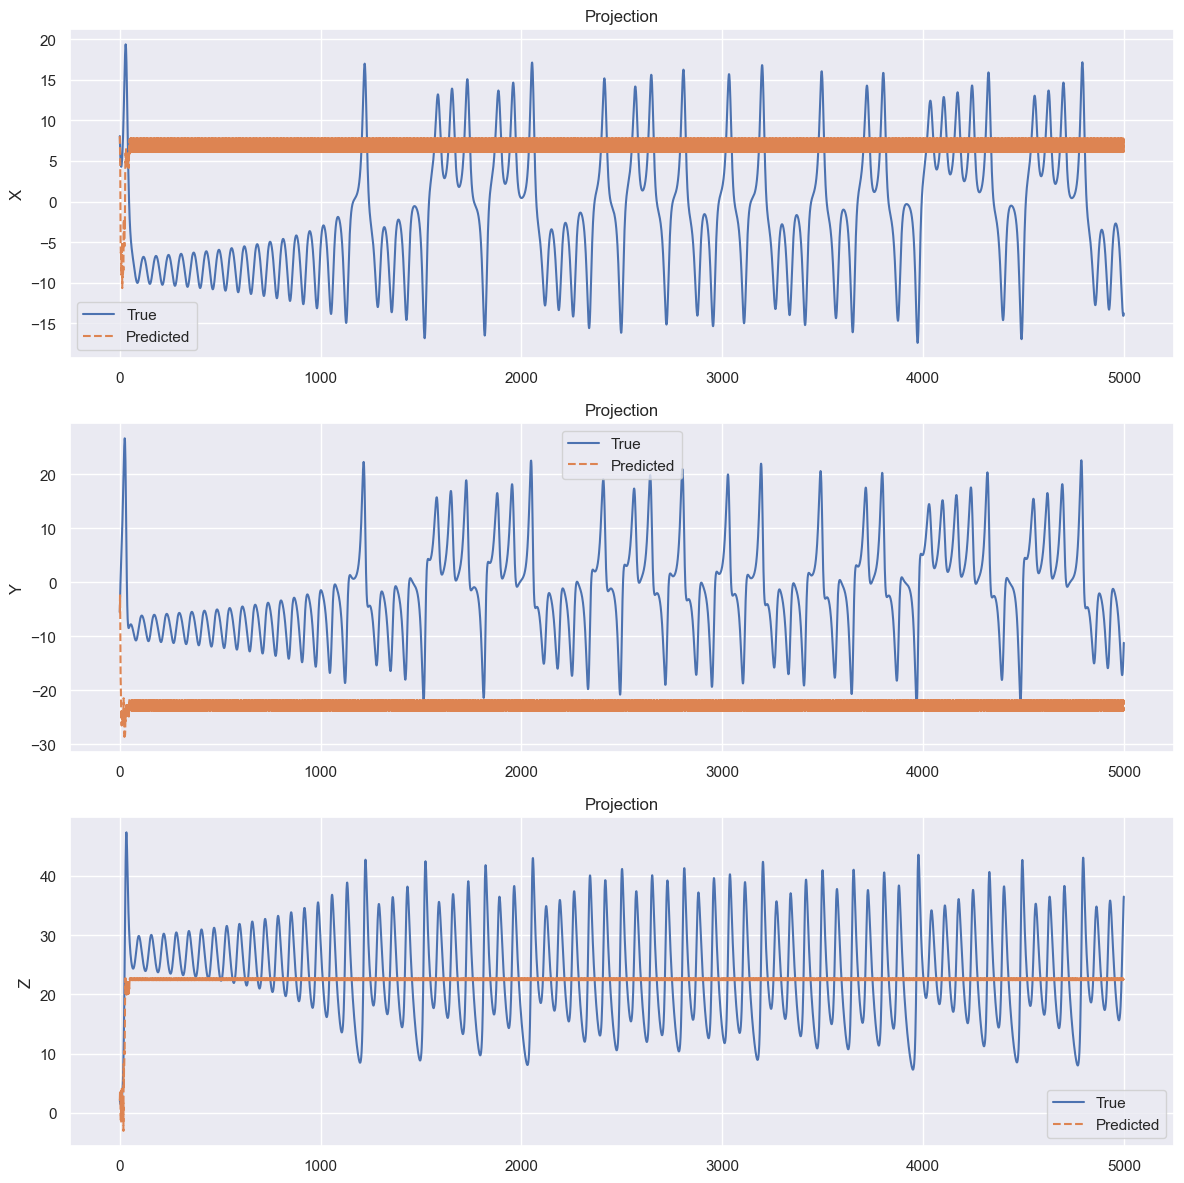

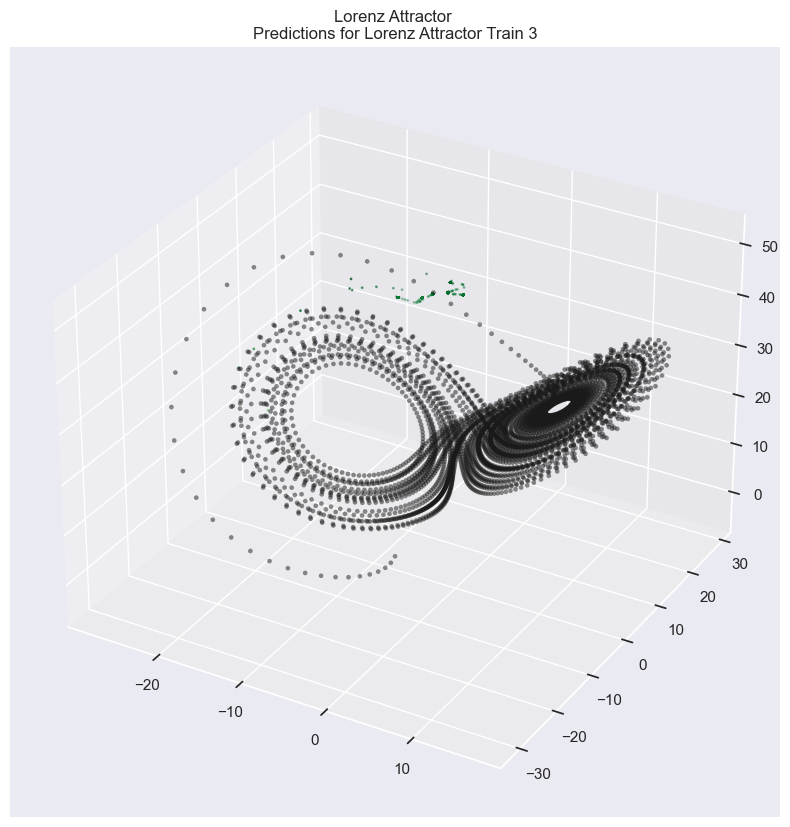

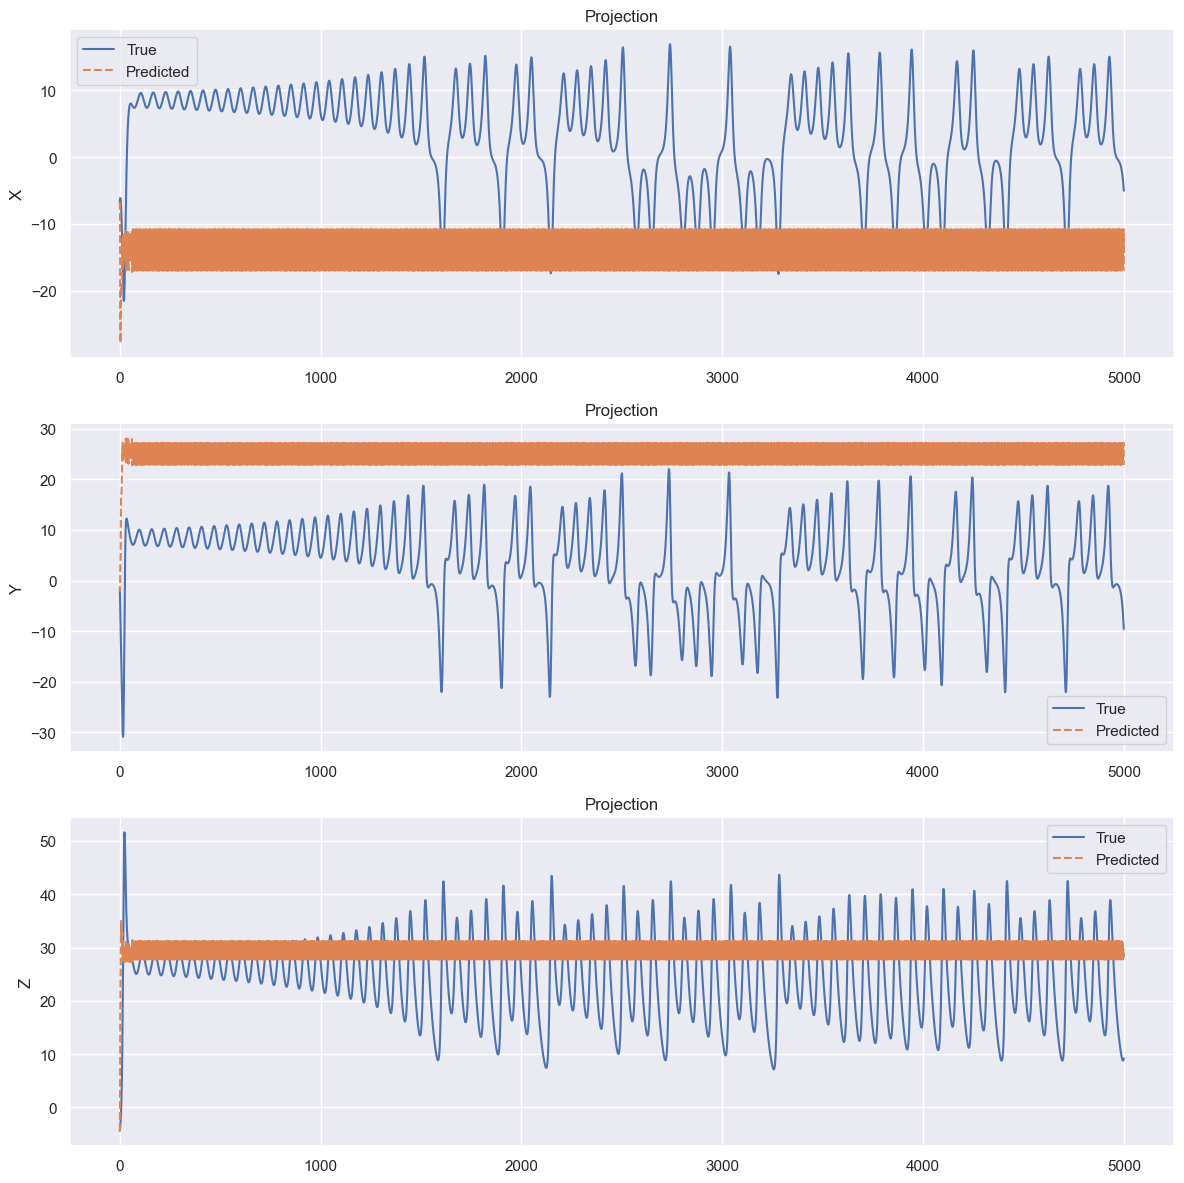

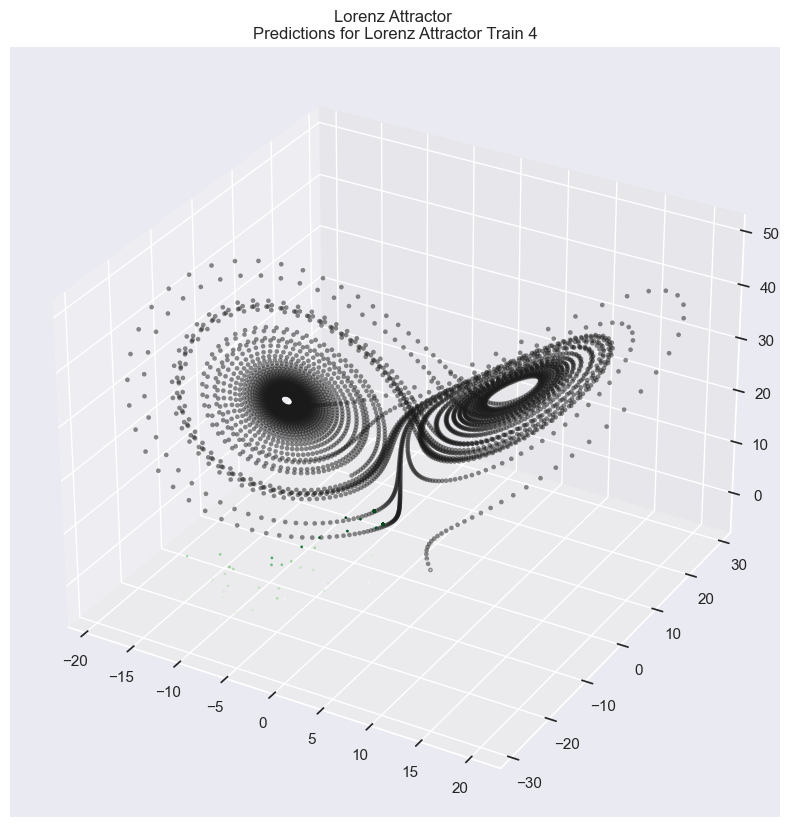

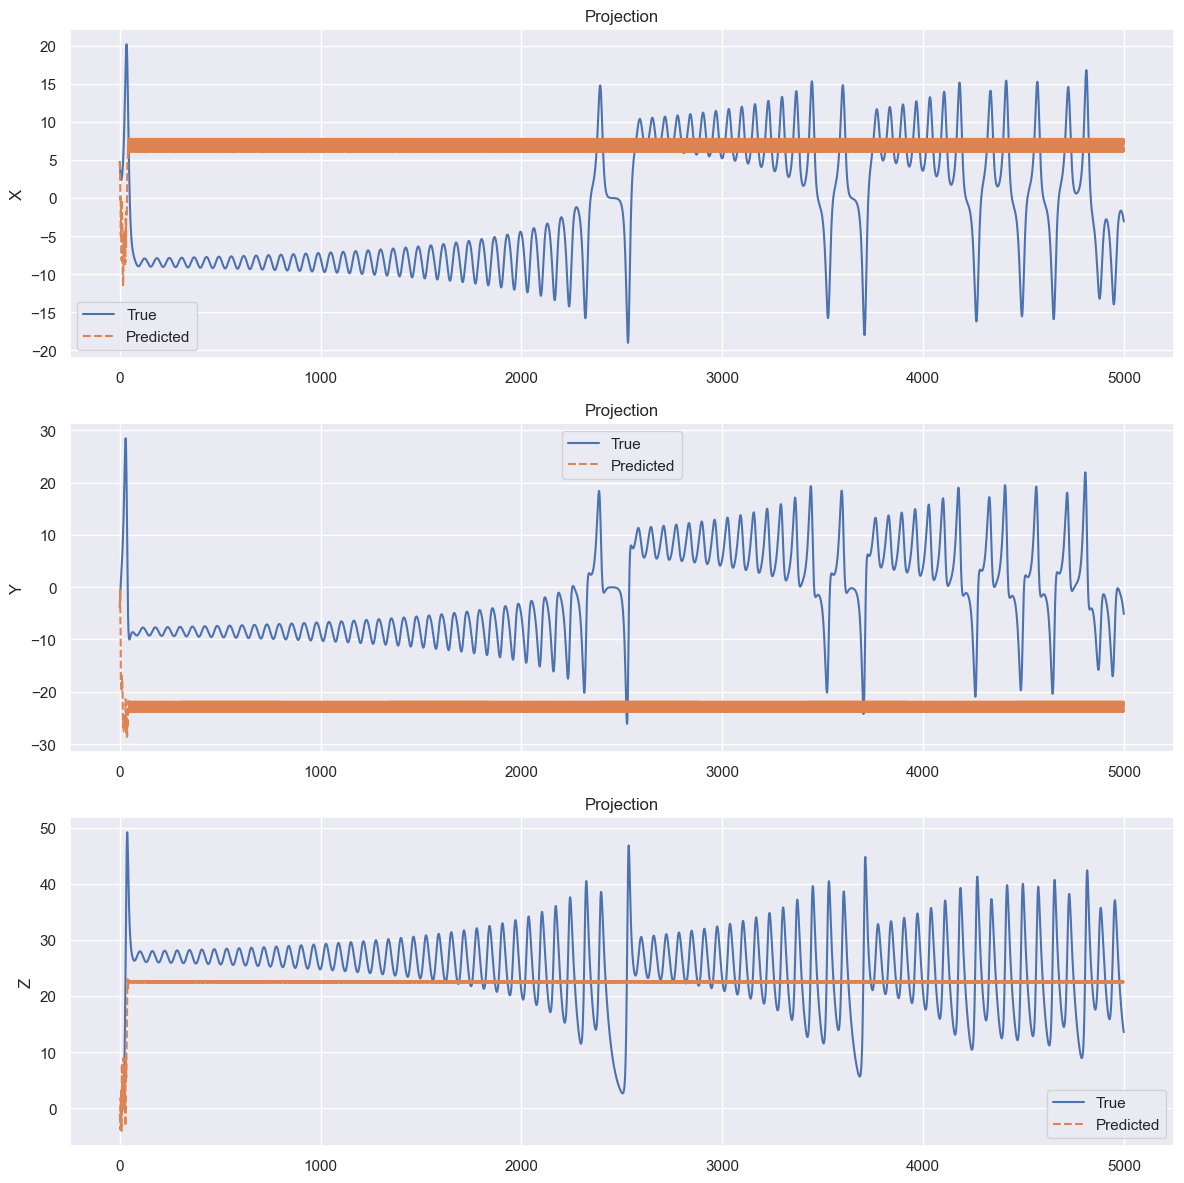

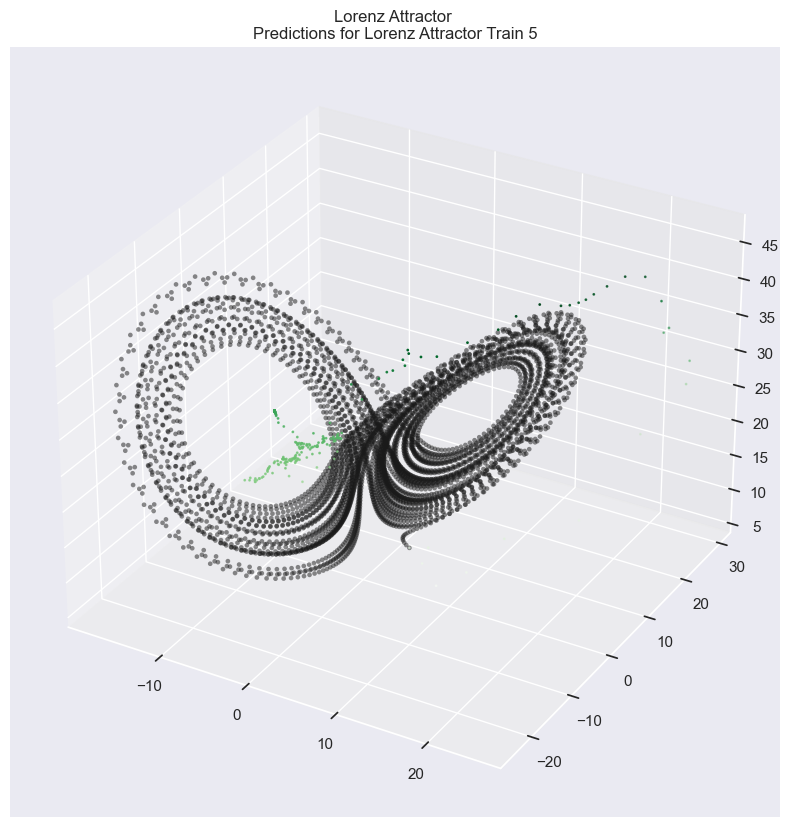

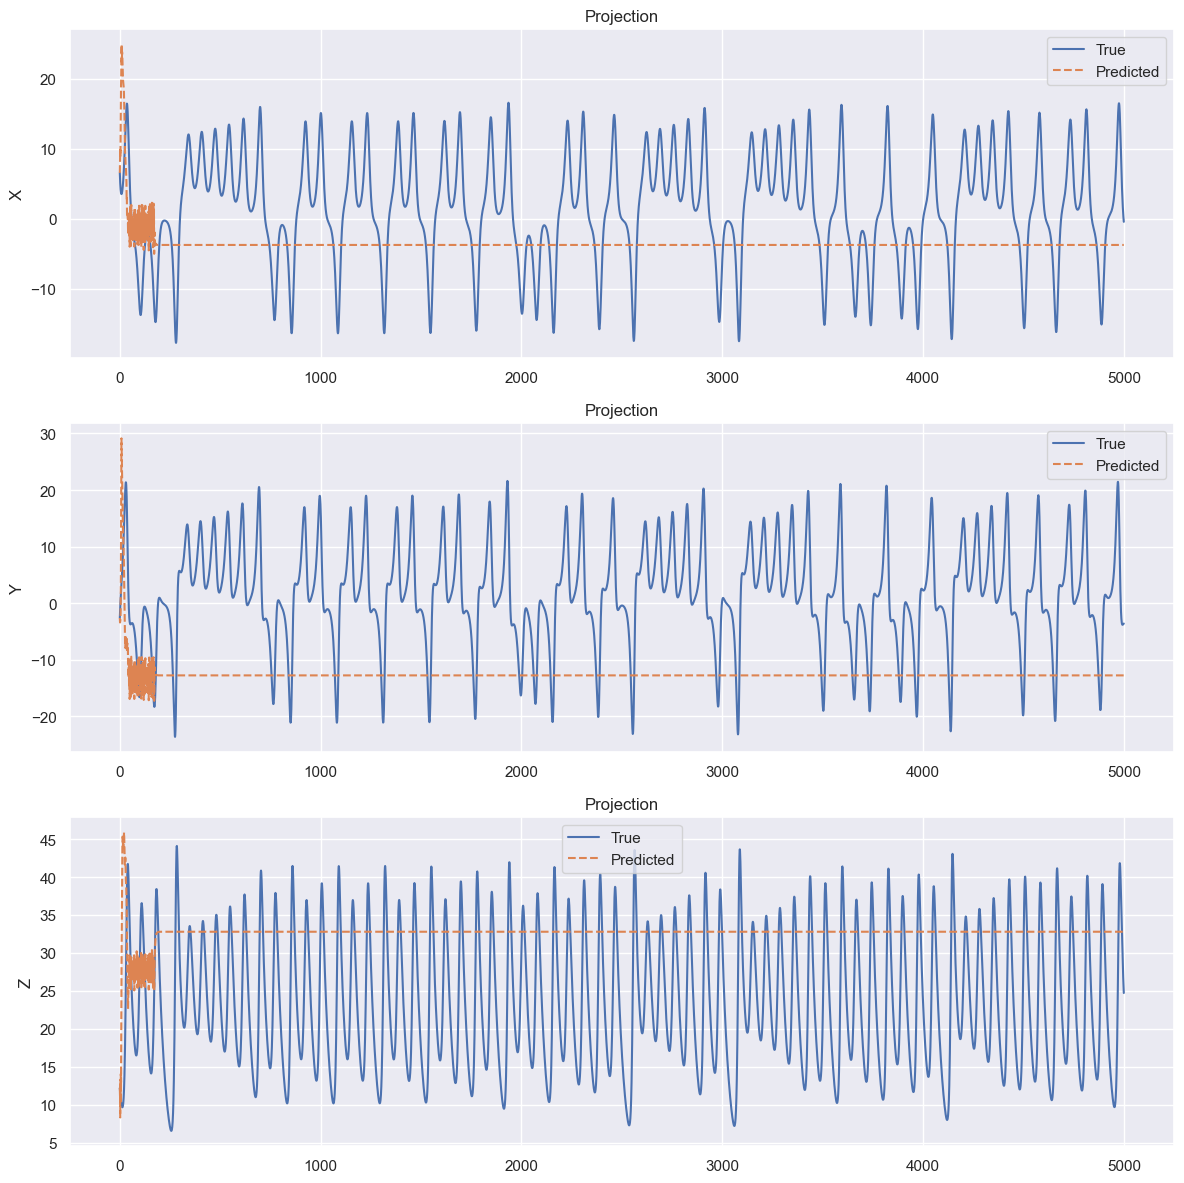

In [405]:
tr_preds,tr_losses = evaluate(test_model,train,label='Train')

In [407]:
tr_preds = torch.stack(tr_preds)

In [410]:
tr_preds.shape

torch.Size([6, 5000, 1, 3])

In [409]:
tr_preds = tr_preds.squeeze(1).unsqueeze(2)

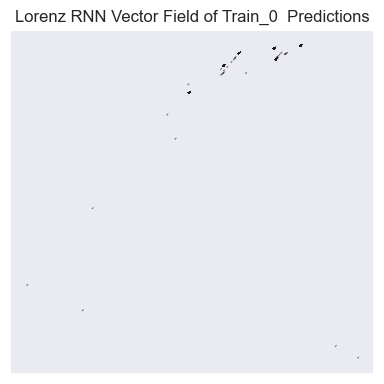

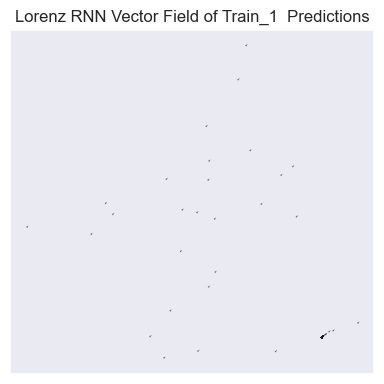

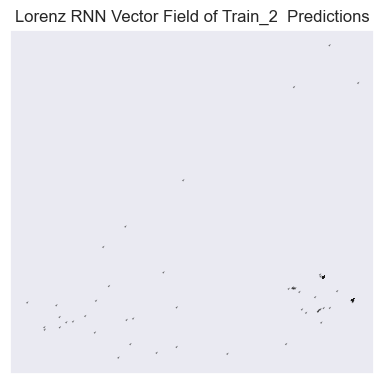

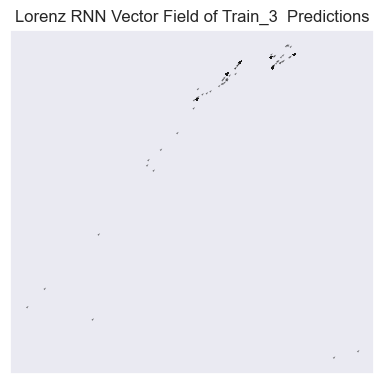

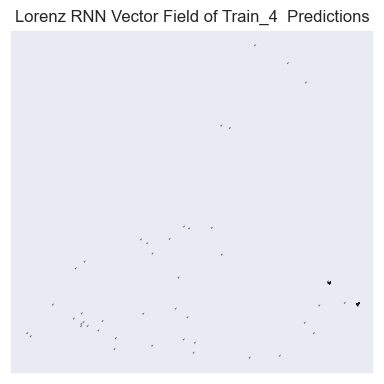

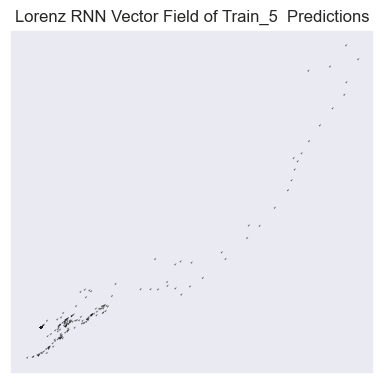

In [414]:
plot_vector_field(tr_preds,label='Train')